In [111]:
from qiskit import IBMQ 

In [112]:
IBMQ.save_account('65fbe3fea2d78c386a26d433f8f87b474b1bfa98596f0d04c76917ee55f25fa70757c61109b5a38b3b665c790e92324d2beb0bef226019875080e9e5246dbdc6', overwrite = True)

In [565]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.circuit.library import MCMT

# import basic plot tools
from qiskit.visualization import plot_histogram

# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
# provider = IBMQ.get_provider(hub='ibm-q-education', group='yale-uni-2', project='cpsc647-quantum')
# device = provider.get_backend('ibmq_lima') #run on ibmq_lima (5-qbit QC)

ibmqfactory.load_account:WARNING:2022-01-26 00:47:15,925: Credentials are already in use. The existing account in the session will be replaced.


In [566]:
# device_names =  ['ibmq_lima', 'ibmq_bogota', 'ibmq_santiago', 'ibmq_manila', 'ibmq_quito', 'ibmq_belem', 'ibmq_casablanca', 'ibmq_jakarta', 'ibm_lagos', 'ibm_perth'  ]
device_names =  ['ibmq_lima', 'ibmq_bogota', 'ibmq_santiago', 'ibmq_manila', 'ibmq_quito', 'ibmq_belem']
device = [0]*len(device_names)
for i in range(len(device_names)):
    device[i] = provider.get_backend(device_names[i])
    print("Device", i , "=", device[i])


Device 0 = ibmq_lima
Device 1 = ibmq_bogota
Device 2 = ibmq_santiago
Device 3 = ibmq_manila
Device 4 = ibmq_quito
Device 5 = ibmq_belem


In [426]:
# def initialize_s(qc, qubits):
#     """Apply a H-gate to 'qubits' in qc"""
#     for q in qubits:
#         qc.h(q)
#     return qc

# def diffuser(nqubits):
#     qc = QuantumCircuit(nqubits)
#     # Apply transformation |s> -> |00..0> (H-gates)
#     for qubit in range(nqubits):
#         qc.h(qubit)
#     # Apply transformation |00..0> -> |11..1> (X-gates)
#     for qubit in range(nqubits):
#         qc.x(qubit)
#     # Do multi-controlled-Z gate
#     qc.h(nqubits-1)
#     qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
#     qc.h(nqubits-1)
#     # Apply transformation |11..1> -> |00..0>
#     for qubit in range(nqubits):
#         qc.x(qubit)
#     # Apply transformation |00..0> -> |s>
#     for qubit in range(nqubits):
#         qc.h(qubit)
#     # We will return the diffuser as a gate
#     U_s = qc.to_gate()
#     U_s.name = "U$_s$"
#     return U_s

In [428]:
# def grovers_algorithm_3(copies):
#     n = 3 #number of qbits
#     qc = QuantumCircuit(3)
# #     qc.cz(0, 2)
# #     qc.cz(1, 2)

#     oracle_ex3 = qc.to_gate()
#     oracle_ex3.name = "U$_\omega$"
#     grover_circuit = QuantumCircuit(5,5)
# #     grover_circuit = QuantumCircuit(5)
#     grover_circuit.barrier()
#     grover_circuit = initialize_s(grover_circuit, [0,1,2])
#     grover_circuit.append(oracle_ex3, [0,1,2])
#     grover_circuit.append(diffuser(n), [0,1,2])
  
    
#     #========================
#     # Malicious Circuit
#     #========================
    
#     for i in range(copies):    
#         grover_circuit.cx(3,4)
# #         grover_circuit.delay(0)
        
#     #========================
#     grover_circuit.barrier()
# #     grover_circuit.measure_all()
#     grover_circuit.measure([0,1,2],[0,1,2])

    
#     return grover_circuit
    

In [552]:
# M1. Series of CX (with optimization mode = 0) 
# M2. Series of CX+Delay[0] (with optimization mode on) 
# M3. Series of CX with alternating controls 
# M4. Series of CX+H+H 
# M5. Series of X 
# M6. Series of Y 
# M7. Series of Z 
# M8. Series of H 
# M9. Series of CX alternating between 3 Qubits 
# M10. Series of CX steps between 4 Qubits

def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

def grovers_algorithm(copies, mal_type): # k- decides the depth of the malicious circuit and d is the delay value
    
    if (mal_type == 'M10' or mal_type == 'M11'):
        n = 6
    
    elif (mal_type == 'M9'):
        n = 5
    elif (mal_type == 'M12'):
        n = 2
    else:
        n = 4     
    
#     grover_circuit = QuantumCircuit(n)
    grover_circuit = QuantumCircuit(n)
    
    grover_circuit.barrier()
############## VICTIM's CIRCUIT ######################    
    grover_circuit = initialize_s(grover_circuit, [0,1])
   
    grover_circuit.cz(0,1) # Oracle

    # Diffusion operator (U_s)
    grover_circuit.h([0,1])
    grover_circuit.z([0,1])
    grover_circuit.cz(0,1)
    grover_circuit.h([0,1])

####################################################

############ MALICIOUS CIRCUIT #####################
    if (mal_type == 'M12'):
        grover_circuit.barrier()
        grover_circuit.delay(10**copies, unit = 'dt')
    
    else:
        for i in range(copies):
            if (mal_type == 'M1'):
                grover_circuit.cx(2,3)

            if (mal_type == 'M2'):
                grover_circuit.cx(2,3)
                grover_circuit.delay(0, qarg=2, unit = 'dt')

            if (mal_type == 'M3'):
                grover_circuit.cx(2,3)
                grover_circuit.cx(3,2)

            if (mal_type == 'M4'):
                grover_circuit.cx(2,3)
                grover_circuit.h(2)
                grover_circuit.delay(0, qarg=2, unit = 'dt')
                grover_circuit.h(2)

            if (mal_type == 'M5'):
                grover_circuit.x(2)
                grover_circuit.delay(0, qarg=2, unit = 'dt')

            if (mal_type == 'M6'):
                grover_circuit.y(2)
                grover_circuit.delay(0, qarg=2, unit = 'dt')

            if (mal_type == 'M7'):
                grover_circuit.z(2)
                grover_circuit.delay(0, qarg=2, unit = 'dt')

            if (mal_type == 'M8'):
                grover_circuit.h(2)
                grover_circuit.delay(0, qarg=2, unit = 'dt')

            if (mal_type == 'M9'):
                grover_circuit.cx(2,3)
                grover_circuit.cx(3,4)

            if (mal_type == 'M10'):
                if i%2==1:
                    grover_circuit.cx(3,2)
                    grover_circuit.cx(4,3)
                    grover_circuit.cx(5,4)
                    grover_circuit.delay(0, qarg = 5)
                else:
                    grover_circuit.cx(5,4)
                    grover_circuit.cx(4,3)
                    grover_circuit.cx(3,2)
                    grover_circuit.delay(0, qarg = 2)

            if (mal_type == 'M11'):
                grover_circuit.cx(4,5)
                grover_circuit.delay(0, qarg=4, unit = 'dt')


            
####################################################

    grover_circuit.barrier()
    grover_circuit.measure_all()
#     grover_circuit.measure(0,0)
#     grover_circuit.measure(1,1)
    
    return grover_circuit

In [596]:
ga = grovers_algorithm(0, 'M12')
print(ga)

         ░ ┌───┐   ┌───┐┌───┐   ┌───┐ ░ ┌──────────────┐ ░  ░ ┌─┐   
   q_0: ─░─┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├─░─┤ Delay(1[dt]) ├─░──░─┤M├───
         ░ ├───┤ │ ├───┤├───┤ │ ├───┤ ░ ├──────────────┤ ░  ░ └╥┘┌─┐
   q_1: ─░─┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├─░─┤ Delay(1[dt]) ├─░──░──╫─┤M├
         ░ └───┘   └───┘└───┘   └───┘ ░ └──────────────┘ ░  ░  ║ └╥┘
meas: 2/═══════════════════════════════════════════════════════╩══╩═
                                                               0  1 


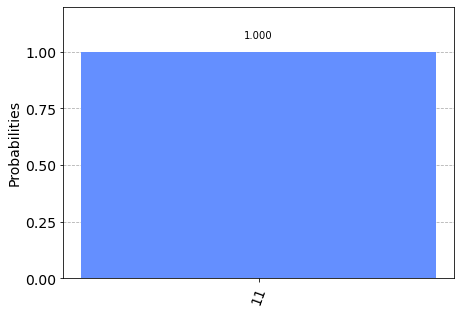

In [597]:
aer_sim = Aer.get_backend('aer_simulator')
# transpiled_circuit = transpile(qc, aer_sim)
transpiled_circuit = transpile(ga, aer_sim)
qobj = assemble(transpiled_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [581]:
# from qiskit.transpiler import CouplingMap
# # cmap = CouplingMap([(0, 1), (1, 2), (2, 3), (3, 4)])
# cmap = CouplingMap()
# cmap.add_physical_qubit(0)
# cmap.add_physical_qubit(1)
# cmap.add_physical_qubit(4)
# cmap.add_physical_qubit(5)
# cmap.add_edge(0,1)
# cmap.add_edge(4,5)

Running on device:  ibmq_quito


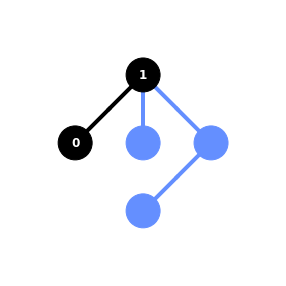

In [603]:

from qiskit.tools.monitor import job_monitor

backend = device[4]
print("Running on device: ", backend)

transpiled_ga = transpile(ga, backend, optimization_level=3, scheduling_method='alap', seed_transpiler = 2 )
# transpiled_ga = transpile(ga, backend, optimization_level=3, scheduling_method='alap', seed_transpiler = 10 )


# transpiled_ga = transpile(ga, backend, initial_layout = [2,1,3,5], optimization_level=3, scheduling_method='alap')
# transpiled_ga = transpile(ga, backend, initial_layout = [1,2,5,6], optimization_level=3, scheduling_method='alap')

from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_circuit_layout
plot_circuit_layout(transpiled_ga, backend = backend)

In [604]:
job = backend.run(transpiled_ga)
job_monitor(job, interval=2)

Job Status: job has successfully run


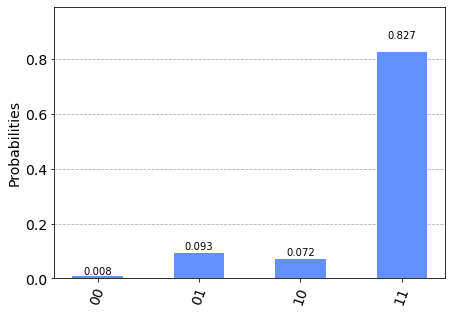

In [605]:
results = job.result()
answer = results.get_counts()
plot_histogram(answer)

In [593]:
plot_histogram(answer).savefig('line_plot.pdf')  

In [594]:
answer

{'00': 50, '01': 262, '10': 135, '11': 577}

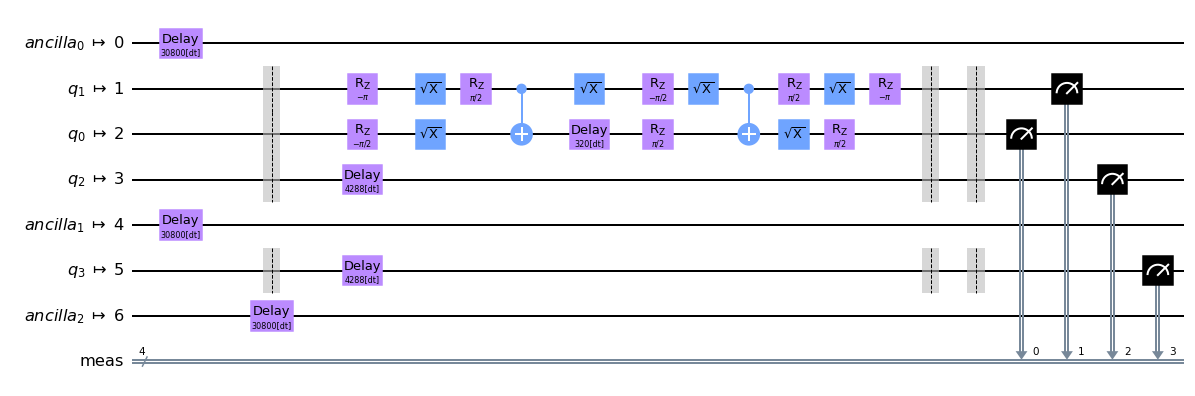

In [527]:
transpiled_ga.draw('mpl')

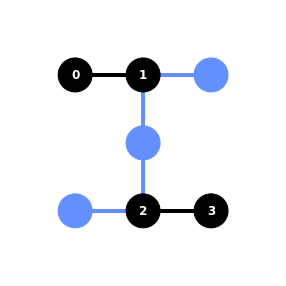

In [433]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_circuit_layout
plot_circuit_layout(transpiled_ga, backend = backend)

In [571]:
# transpiled_ga.draw('mpl')
transpiled_ga.draw('latex_source', filename='./grovers_circuit.tex')
!pdflatex grovers_circuit.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.23 (MiKTeX 21.10)
entering extended mode
(grovers_circuit.tex
LaTeX2e <2021-06-01> patch level 1
L3 programming layer <2021-10-12>
(C:\Users\sd982\AppData\Local\Programs\MiKTeX\tex/latex/standalone\standalone.c
ls
Document Class: standalone 2018/03/26 v1.3a Class to compile TeX sub-files stan
dalone
(C:\Users\sd982\AppData\Local\Programs\MiKTeX\tex/latex/tools\shellesc.sty)
(C:\Users\sd982\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifluatex.sty
(C:\Users\sd982\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\sd982\AppData\Local\Programs\MiKTeX\tex/latex/xkeyval\xkeyval.sty
(C:\Users\sd982\AppData\Local\Programs\MiKTeX\tex/generic/xkeyval\xkeyval.tex
(C:\Users\sd982\AppData\Local\Programs\MiKTeX\tex/generic/xkeyval\xkvutils.tex
(C:\Users\sd982\AppData\Local\Programs\MiKTeX\tex/generic/xkeyval\keyval.tex)))
)
(C:\Users\sd982\AppData\Local\Programs\MiKTeX\tex/latex/standalone\standalone.c
fg) (C:\Users\sd982\AppData\Lo

In [577]:
from qiskit.tools.monitor import job_monitor
import winsound
import time

iterations = 20
f = open("GA_CX.txt", "w")
backend = device[0]
answer= [0]*iterations
f.write(str(backend))
f.write(str("\n"))
for i in range(0,iterations,1):
    ga = grovers_algorithm(i,'M1')
    print("Running on device: ", backend)
    transpiled_ga = transpile(ga, backend, optimization_level=0, scheduling_method='alap')
#     transpiled_ga = transpile(ga, backend, optimization_level=0, scheduling_method='alap')
    job = backend.run(transpiled_ga) 
    job_monitor(job, interval=2)

    results = job.result()
    answer[i] = results.get_counts()
    prob = int(answer[i]['0011'])/1000
    
#     answer[i] = results.get_counts()
#     prob = int(answer[i]['11'])/1000
        
    print(i, prob)
    f.write(str(i))
    f.write(str(", "))
    f.write(str(prob))
    f.write(str("\n"))
    
f.close()

# Beeper
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
for i in range(10):
    winsound.Beep(frequency, duration)
    time.sleep(1)

Running on device:  ibmq_lima
Job Status: job has successfully run
0 0.824
Running on device:  ibmq_lima
Job Status: job has successfully run
1 0.766
Running on device:  ibmq_lima
Job Status: job has successfully run
2 0.655
Running on device:  ibmq_lima
Job Status: job has successfully run
3 0.613
Running on device:  ibmq_lima
Job Status: job has successfully run
4 0.562
Running on device:  ibmq_lima
Job Status: job has successfully run
5 0.555
Running on device:  ibmq_lima
Job Status: job has successfully run
6 0.534
Running on device:  ibmq_lima
Job Status: job has successfully run
7 0.533
Running on device:  ibmq_lima
Job Status: job has successfully run
8 0.103
Running on device:  ibmq_lima
Job Status: job has successfully run
9 0.254
Running on device:  ibmq_lima
Job Status: job has successfully run
10 0.286
Running on device:  ibmq_lima
Job Status: job has successfully run
11 0.474
Running on device:  ibmq_lima
Job Status: job has successfully run
12 0.055
Running on device:  ib

KeyboardInterrupt: 

In [569]:
answer

[0,
 0,
 0,
 {'0000': 4,
  '0001': 17,
  '0010': 44,
  '0011': 254,
  '0100': 7,
  '0101': 9,
  '0110': 32,
  '0111': 192,
  '1000': 8,
  '1001': 13,
  '1010': 41,
  '1011': 192,
  '1100': 2,
  '1101': 15,
  '1110': 26,
  '1111': 168},
 {'0000': 3,
  '0001': 25,
  '0010': 22,
  '0011': 262,
  '0100': 1,
  '0101': 17,
  '0110': 18,
  '0111': 222,
  '1000': 2,
  '1001': 13,
  '1010': 14,
  '1011': 202,
  '1100': 2,
  '1101': 13,
  '1110': 9,
  '1111': 199},
 {'0000': 6,
  '0001': 43,
  '0010': 16,
  '0011': 203,
  '0100': 3,
  '0101': 31,
  '0110': 20,
  '0111': 216,
  '1000': 3,
  '1001': 26,
  '1010': 22,
  '1011': 219,
  '1100': 1,
  '1101': 27,
  '1110': 13,
  '1111': 175},
 0,
 0]

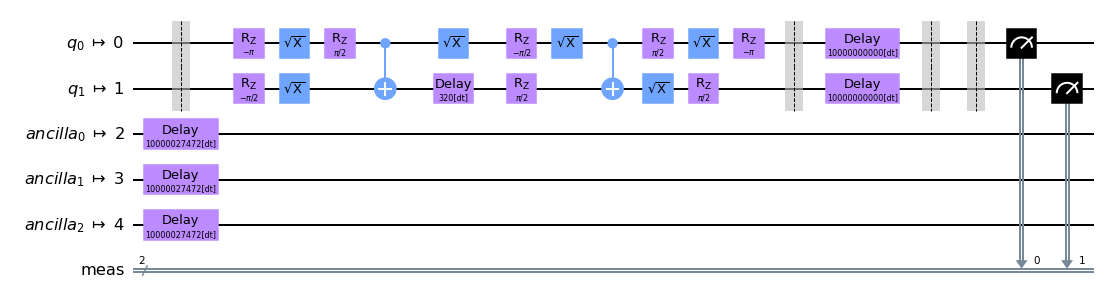

In [557]:
transpiled_ga.draw('mpl')

# Duration Analysis Code

In [ ]:
transpiled_q = [0]*len(device)
for i in range(len(device)):
    print("============================================")
    print(device[i])
#     transpiled_q[i] = transpile(q, device[i], optimization_level=3, scheduling_method='alap')
    transpiled_q[i] = transpile(malicious_grover, device[i], optimization_level=3, scheduling_method='alap')
    print(transpiled_q[i])
    print("============================================")

In [ ]:
j = 0
print(device[j])
transpiled_q[j].draw('mpl')

In [157]:
from qiskit.transpiler import CouplingMap
coupling_map = CouplingMap([[0,0],[1,1],[3,5],[4,6]])

In [158]:
coupling_map

In [182]:
!pip install neato